In [1]:
# Importing everything for Time Series

import matplotlib.pyplot as plt  # plots
import numpy as np  # vectors and matrices
import pandas as pd  # tables and data manipulations
import seaborn as sns  # more plots

sns.set()

import warnings  
from itertools import product  # some useful functions

import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.formula.api as smf  # statistics and econometrics
import statsmodels.tsa.api as smt
from dateutil.relativedelta import relativedelta  # working with dates with style
from scipy.optimize import minimize  # for function minimization
from tqdm.notebook import tqdm
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore") # `do not disturbe` mode

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error, median_absolute_error,
                             r2_score)


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [2]:
df = pd.read_csv("orders.csv")
df

,created_at_utc,tariff_class,tariff_internal_name,status,taxi_status,vehicle_model,vehicle_color,vehicle_car_region,payment_cost,payment_currency_code,driver_call_model
0,1622145491,Эконом,econom,cancelled,waiting,Kia Rio,белый,34,52.00,RUB,no_call
1,1622145422,Эконом,econom,cancelled,driving,LADA (ВАЗ) Granta,серый,34,0.00,RUB,no_call
2,1622145212,Эконом,econom,finished,complete,Renault Logan,белый,34,104.70,RUB,on_demand
3,1622054615,Эконом,econom,finished,complete,LADA (ВАЗ) Granta,белый,34,120.00,RUB,on_demand
4,1622045036,Эконом,econom,finished,complete,LADA (ВАЗ) Granta,белый,34,115.50,RUB,on_demand
...,...,...,...,...,...,...,...,...,...,...,...
1200,1617028952,Эконом,econom,finished,complete,LADA (ВАЗ) Largus,белый,34,472.40,RUB,no_call
1201,1617028458,Эконом,econom,cancelled,driving,LADA (ВАЗ) Granta,белый,34,0.00,RUB,no_call
1202,1617025078,Эконом,econom,finished,complete,LADA (ВАЗ) Granta,серый,34,146.85,RUB,no_call
1203,1616869125,Эконом,econom,cancelled,driving,LADA (ВАЗ) Largus,серый,34,0.00,RUB,no_call


## Cleaning and Selecting

In [3]:
#Converting to date-time
df = df[['created_at_utc','payment_cost']]
df['created_at_utc'] = pd.to_datetime(df.created_at_utc,unit='s')
df['created_at_utc'] = df['created_at_utc'].dt.date
df['created_at_utc'] = pd.to_datetime(df.created_at_utc,unit=None)
df = df.groupby('created_at_utc').payment_cost.mean()
df = df.reset_index()
df.sort_values(by=['created_at_utc'], inplace=True)
df

,created_at_utc,payment_cost
0,2017-09-30,78.775000
1,2017-10-18,438.150000
2,2017-10-19,425.500000
3,2017-10-27,65.550000
4,2017-11-02,96.025000
...,...,...
488,2021-05-23,370.150000
489,2021-05-24,41.762500
490,2021-05-25,261.410000
491,2021-05-26,290.220000


In [4]:
df = df.loc[df['payment_cost']!=0]
df = df.loc[df['created_at_utc'].dt.year == 2021]
df.set_index('created_at_utc', inplace=True)

## Visualization and TS analysis.

<Figure size 1000x600 with 0 Axes>

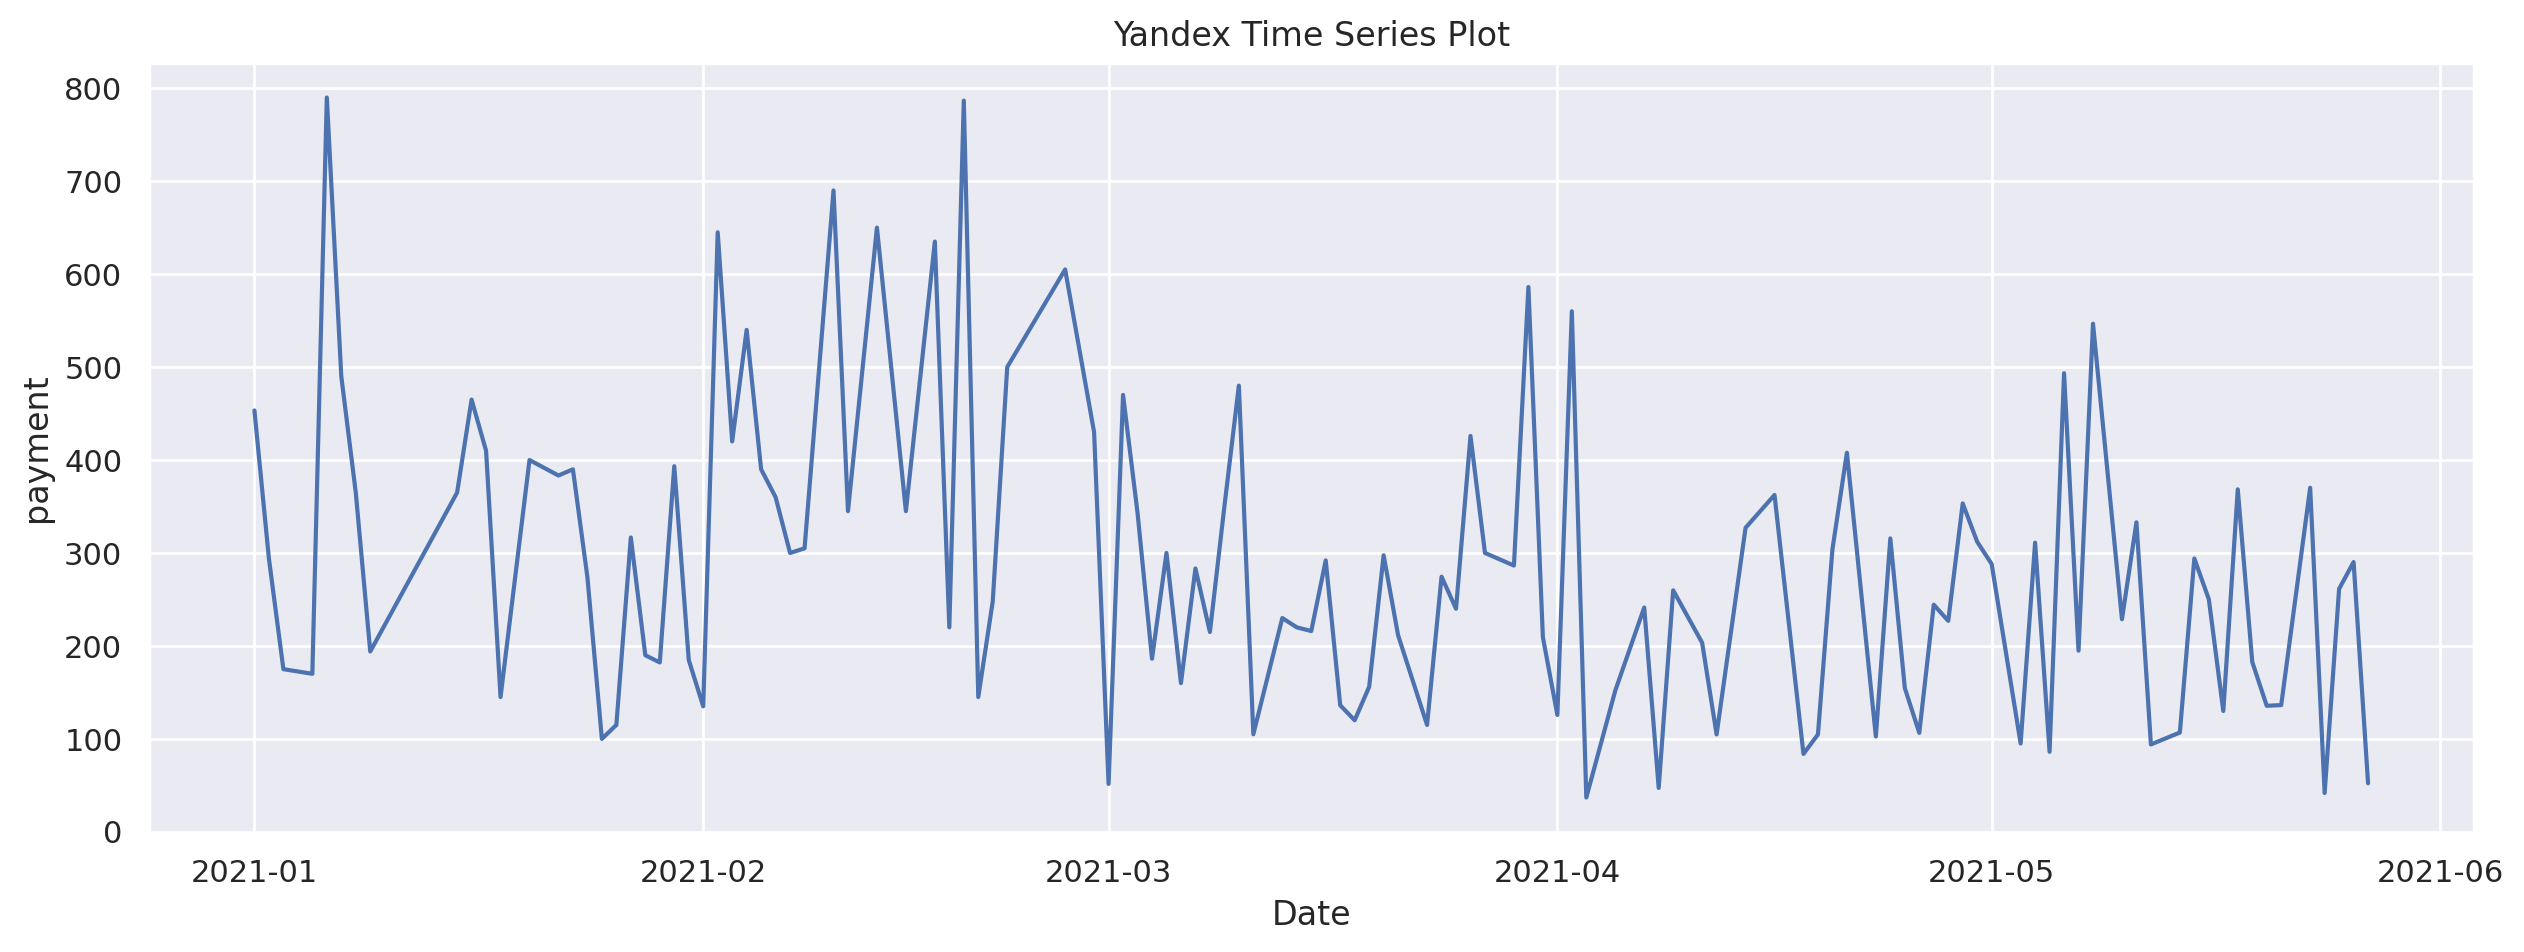

In [5]:
plt.figure(figsize=(10, 6))  # Set figure size

# Plot the time series
plt.figure(figsize=(15, 5))
plt.plot(df['payment_cost'], linestyle='-')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('payment')
plt.title('Yandex Time Series Plot')
# Show plot
plt.show()

In [6]:
def plotMovingAverage(
    series, window, plot_intervals=False, scale=1.96, plot_anomalies=False
):

    """
        series - dataframe with timeseries
        window - rolling window size
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")


        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series > upper_bond] = series[series > upper_bond]
            plt.plot(anomalies, "ro", markersize=10)

    plt.plot(series[window:],  alpha=0.4,label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

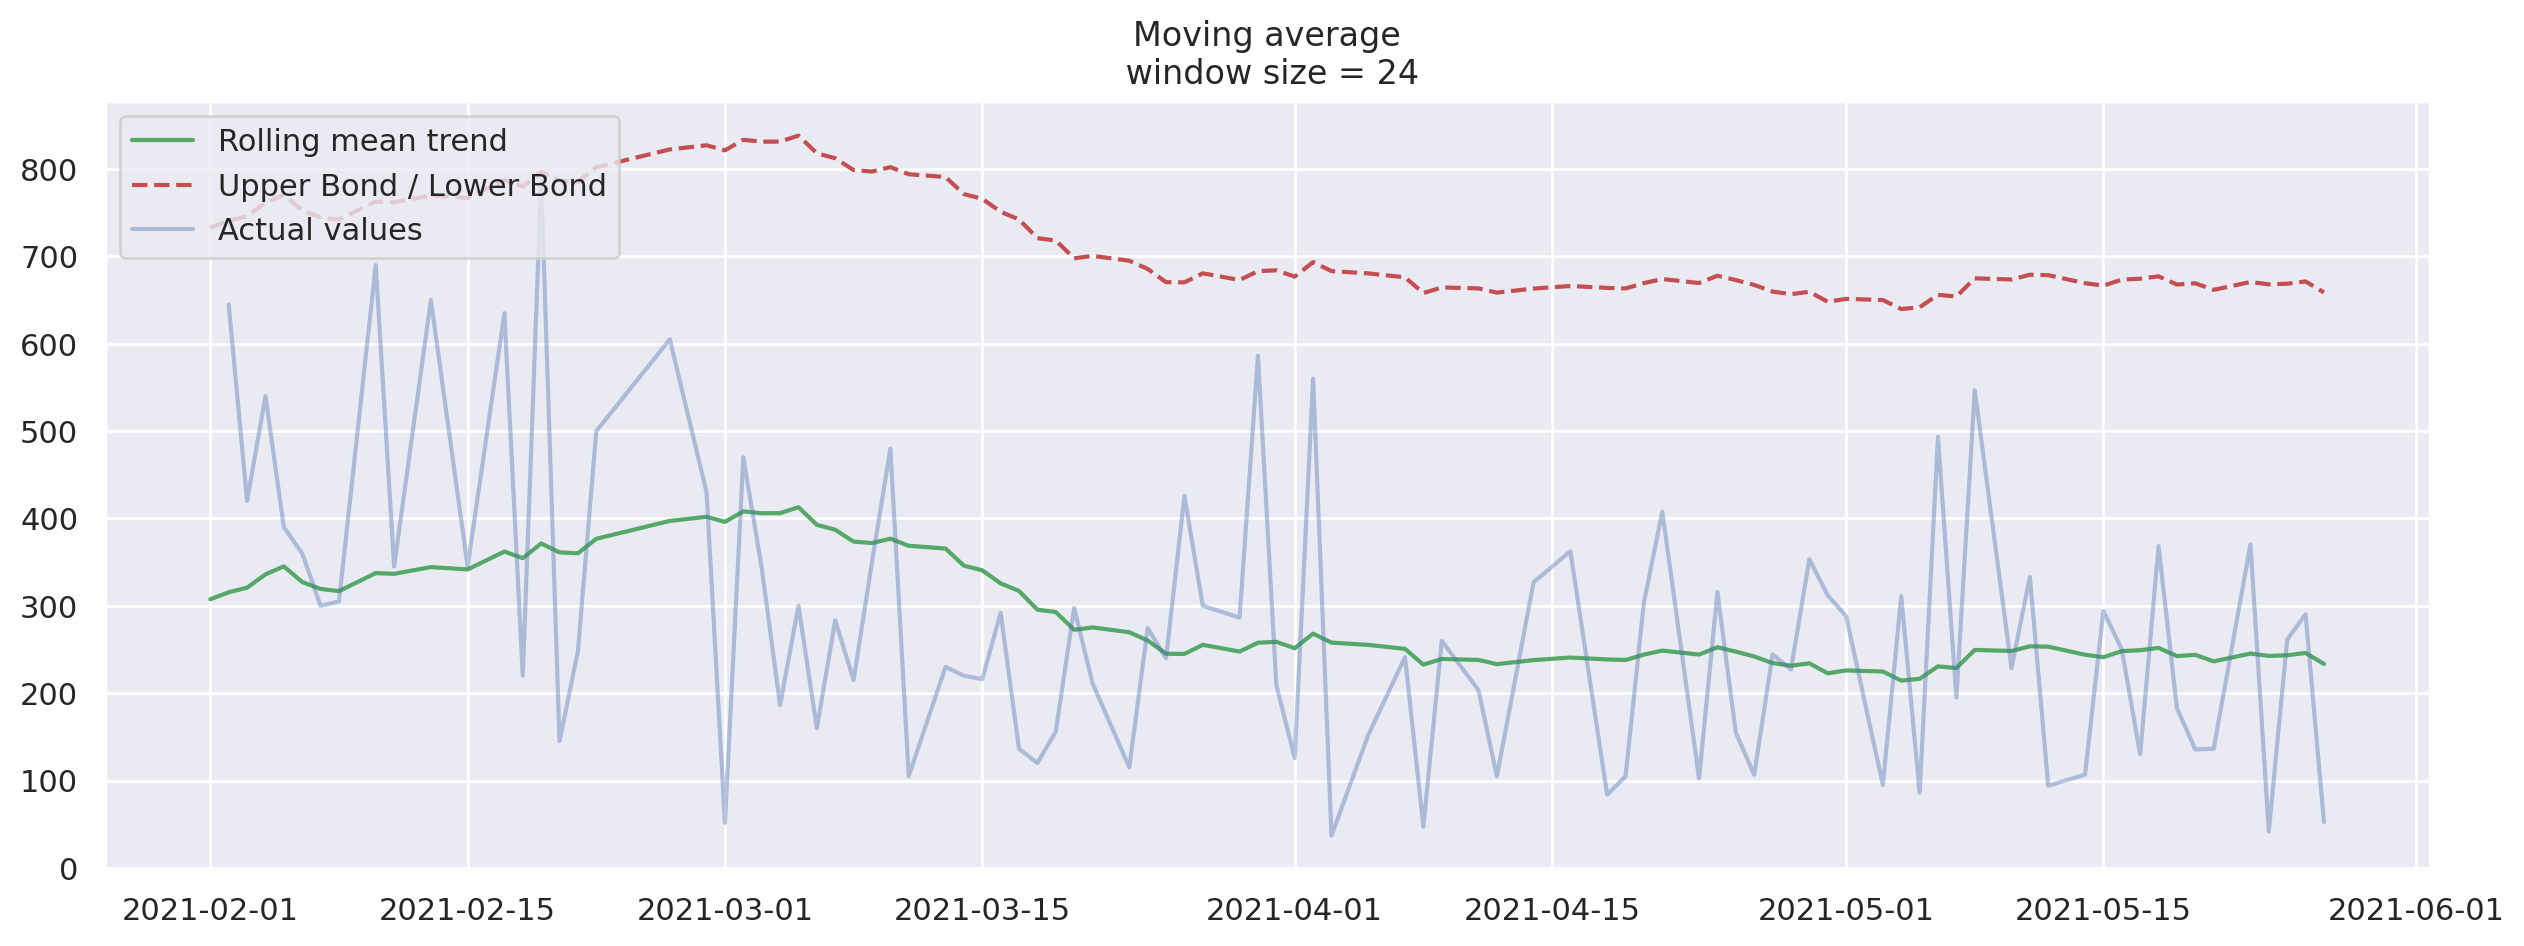

In [7]:
plotMovingAverage(df, 24, plot_intervals=True, plot_anomalies=True)

**Required analysis for ARIMA model. One has to ensure to make Dickey-Fuller p-value = 0 which means that series are stationary and can be predicted by ML model**

In [8]:
def tsplot(y, lags=None, figsize=(12, 7), style="bmh"):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test

        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style):
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        ts_ax.plot(y)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title(
            "Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}".format(p_value)
        )
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

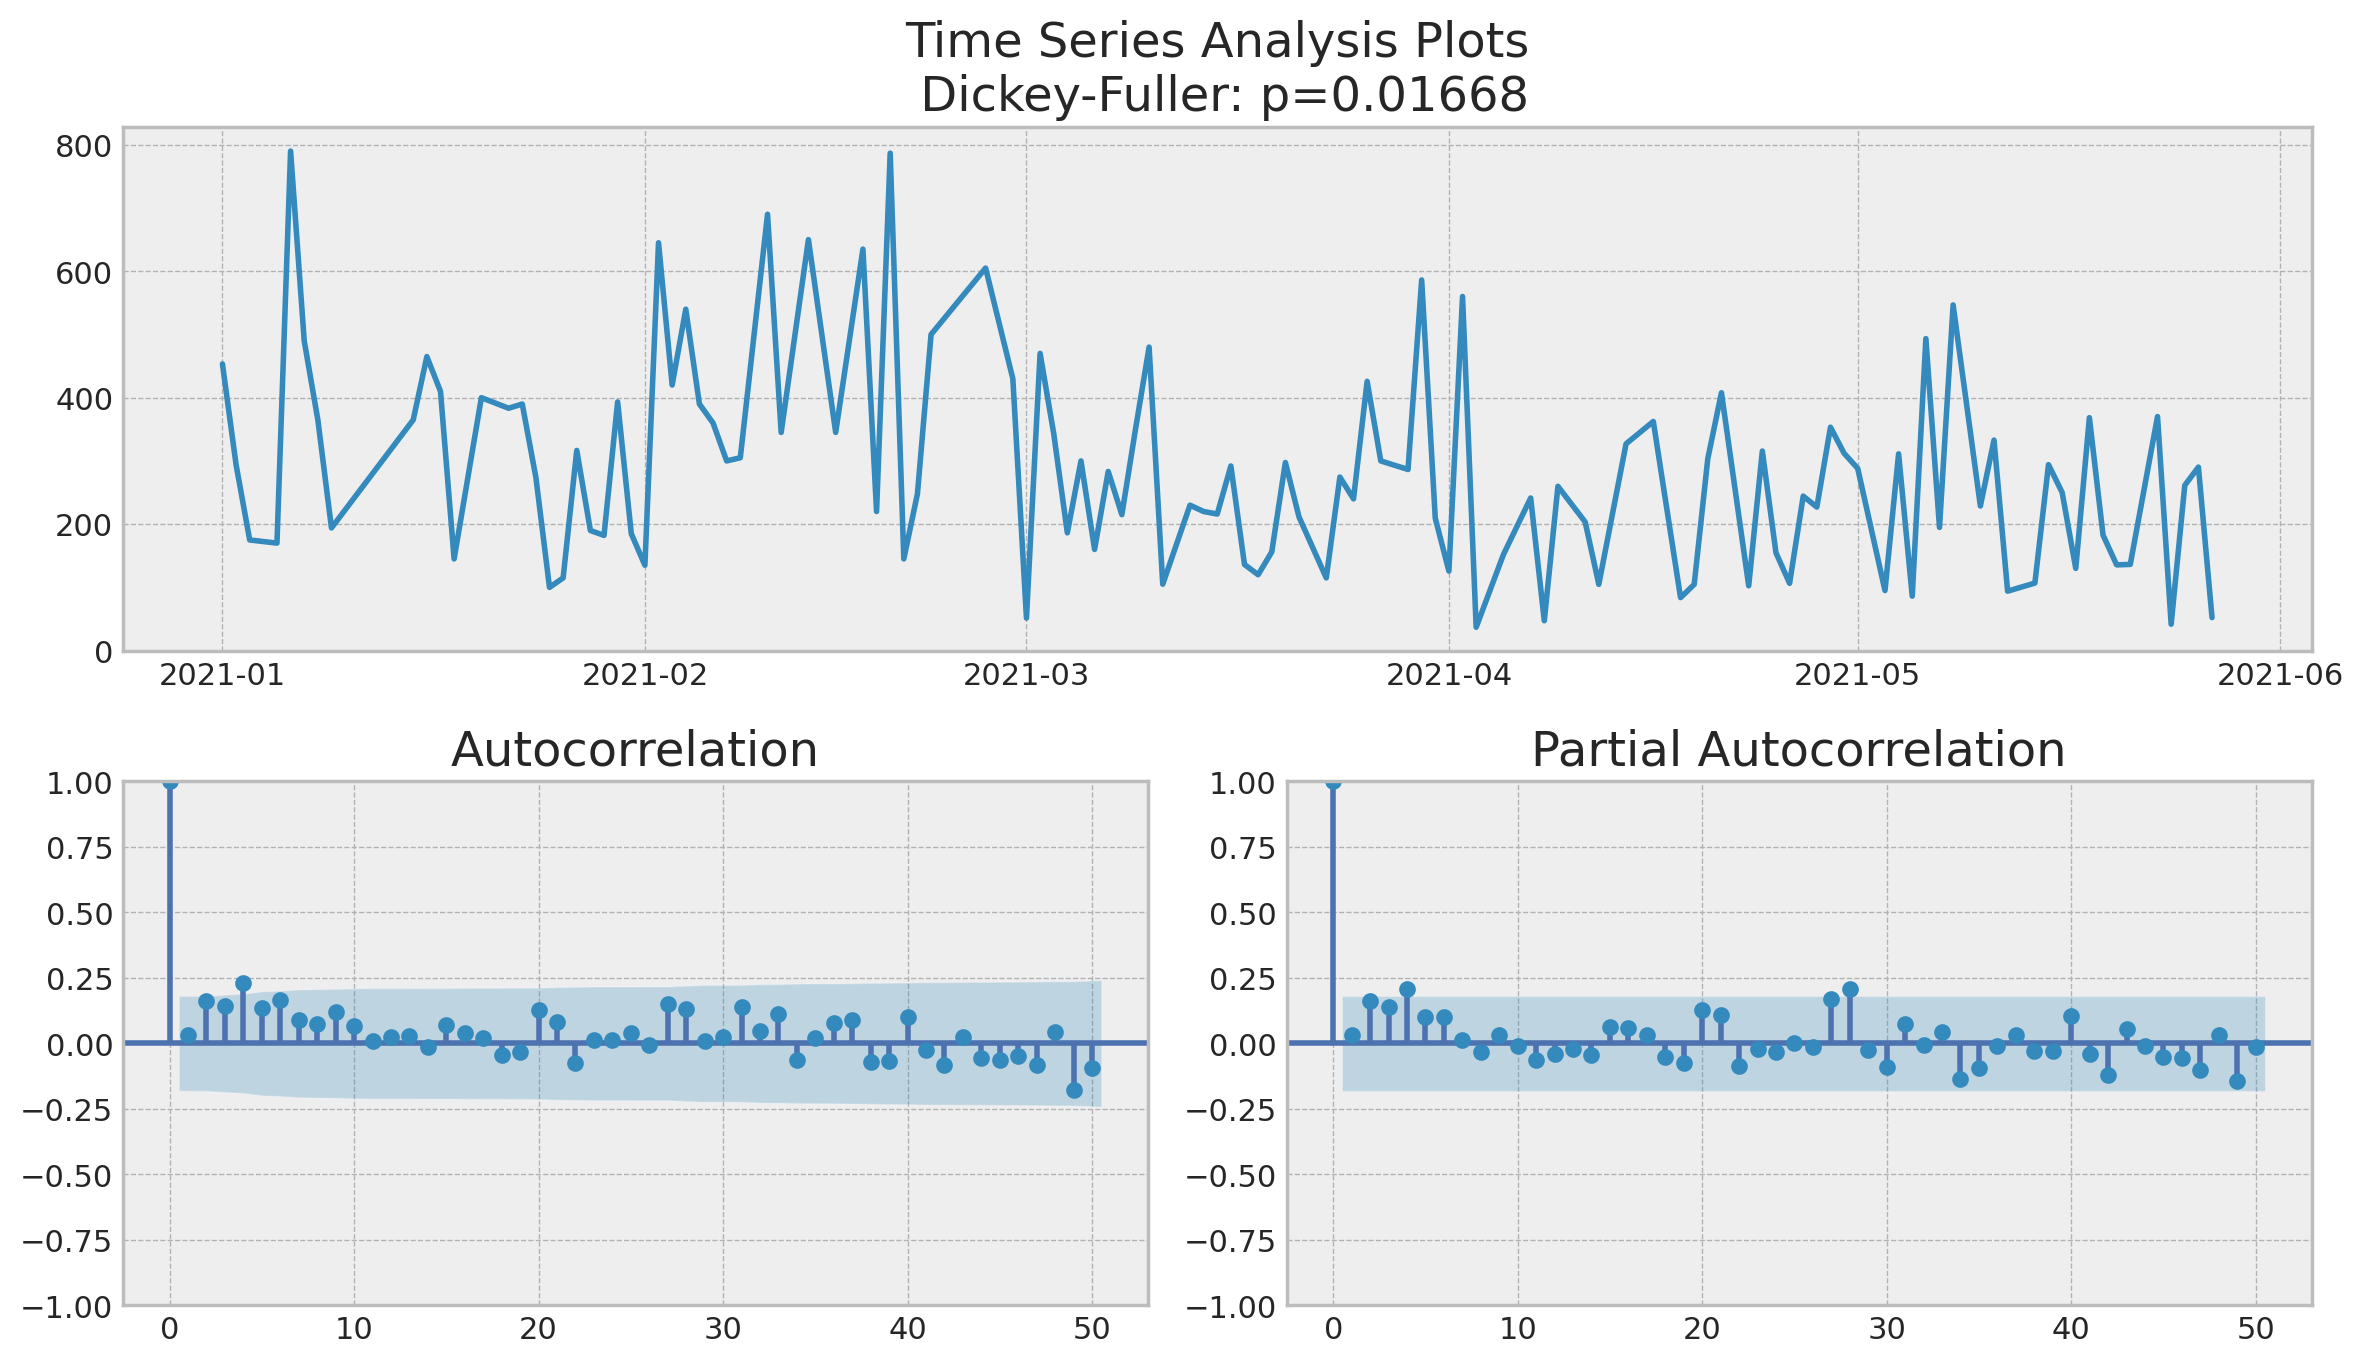

In [9]:
tsplot(df.payment_cost, lags=50)

**Importing lag differences to get read of p-value**

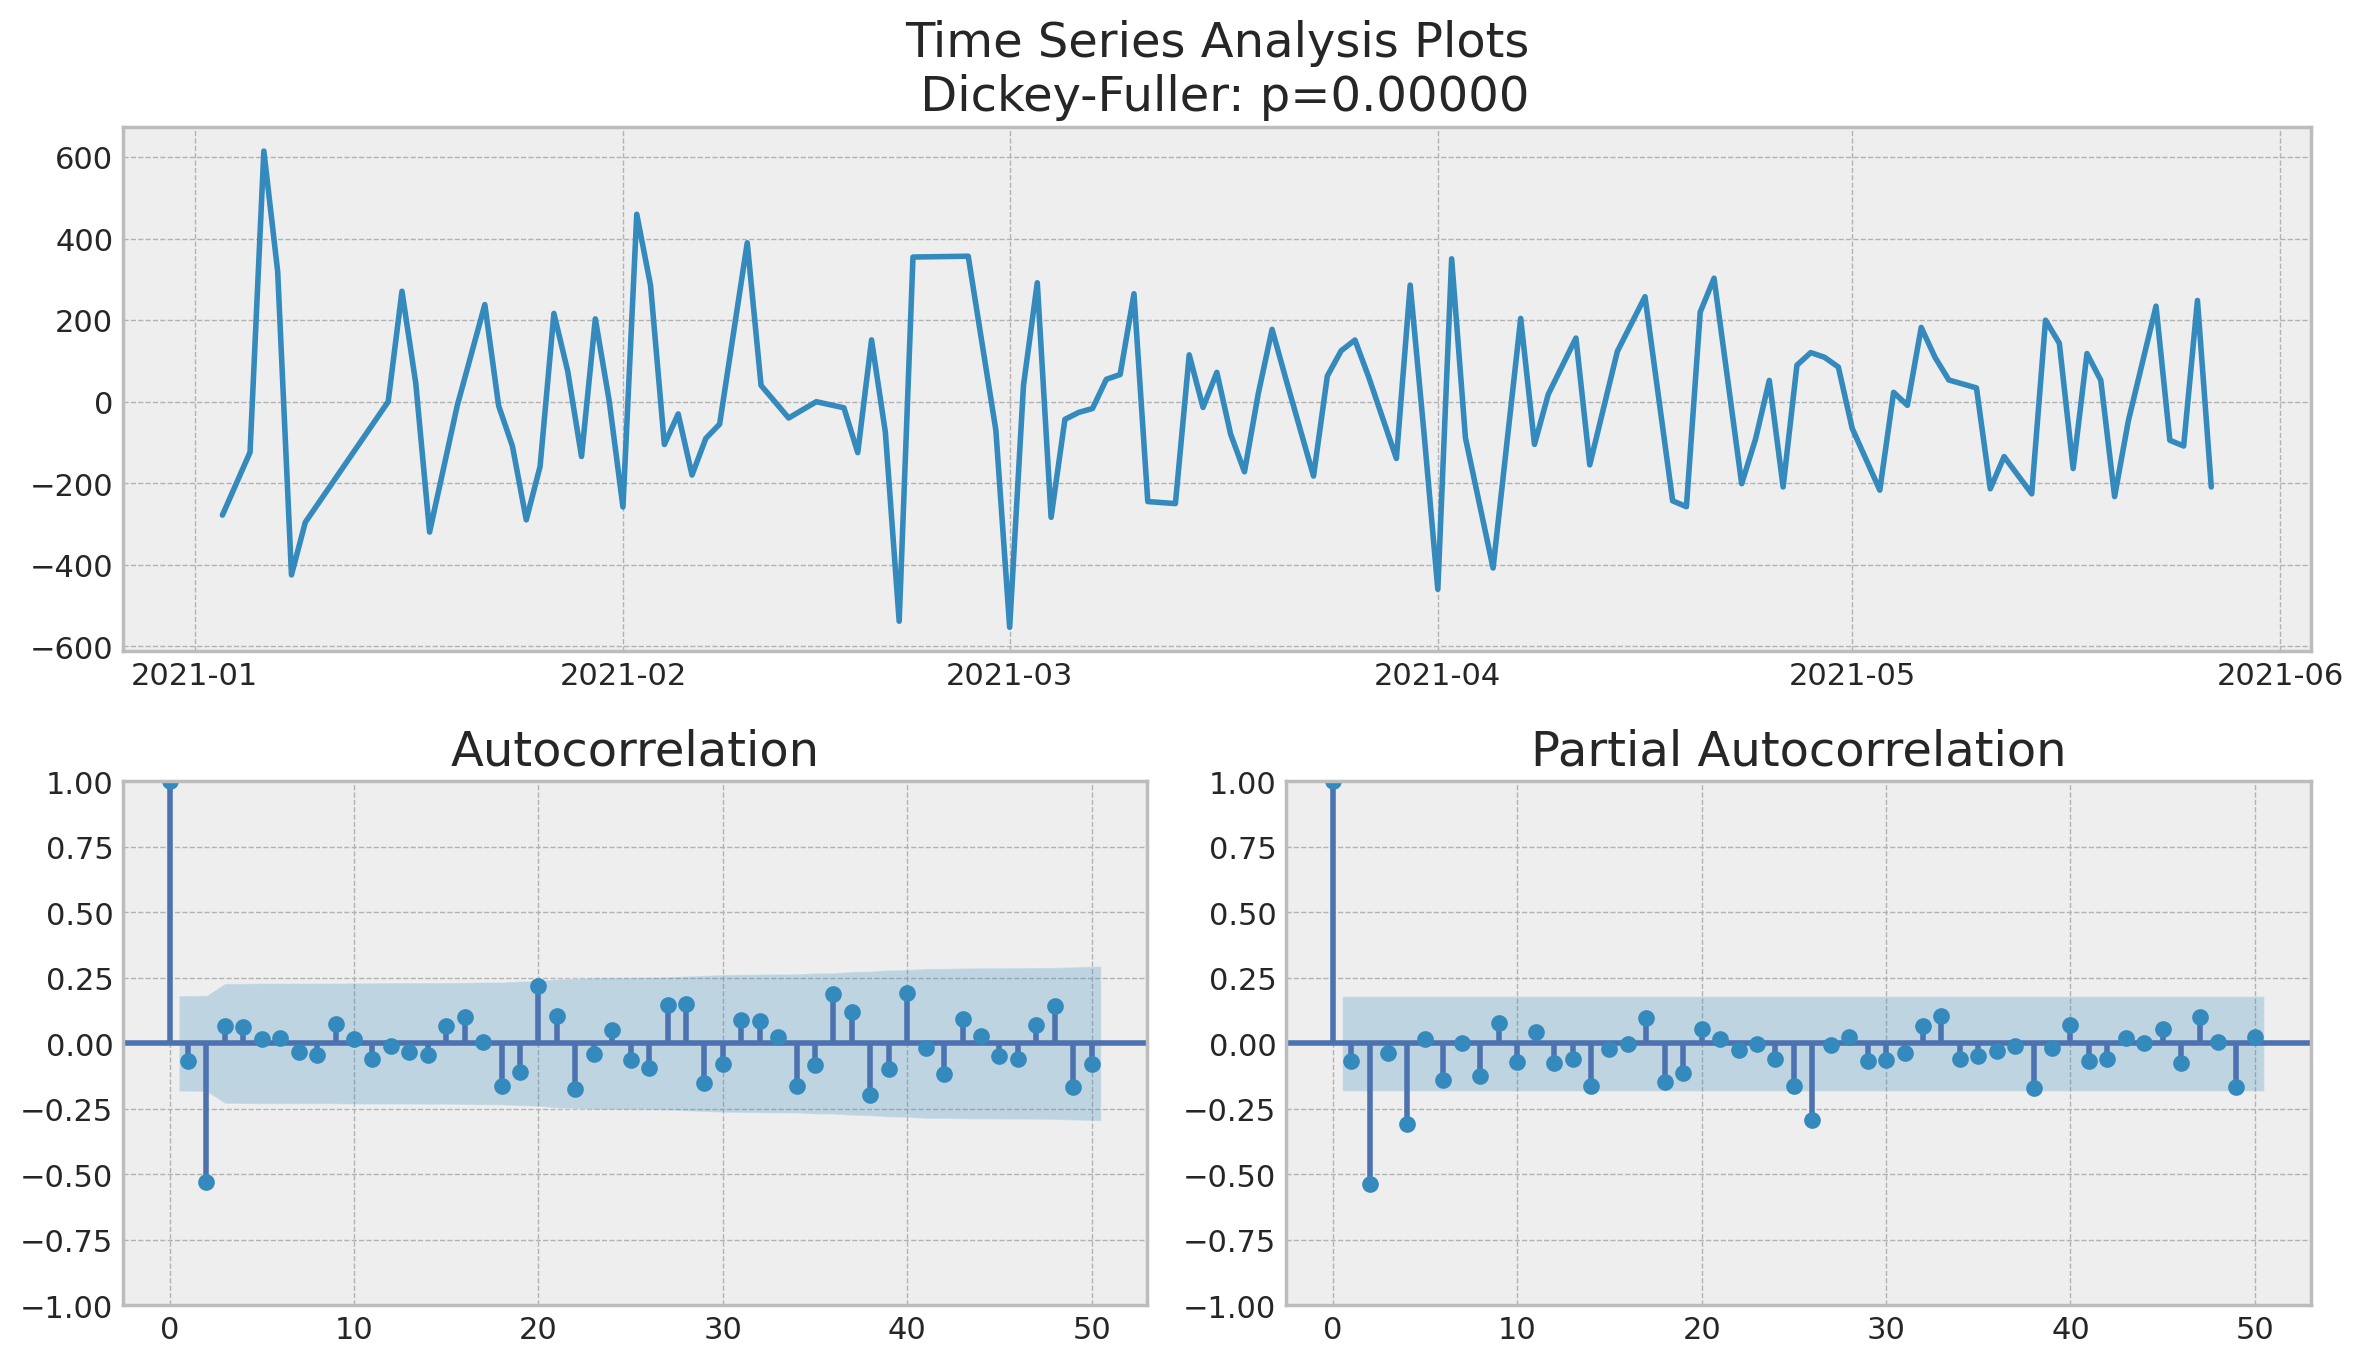

In [10]:
n_shift = 2
df_diff = df.payment_cost - df.payment_cost.shift(n_shift)
tsplot(df_diff[n_shift:], lags=50)

## ARIMA

**Selecting combinations for ARIMA (p,d,q) and then iterate a function that would return list of combinations, where we can choose the most optimised combo**

In [11]:
# setting initial values and some bounds for them
ps = range(1, 4)
ds = range(1,3)
qs = range(1,4)


# creating list with all the possible combinations of parameters
parameters = product(ps, ds, qs)
parameters_list = list(parameters)
len(parameters_list)

18

In [12]:
def optimizeSARIMA(parameters_list):
    """
        Return dataframe with parameters and corresponding AIC

        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order
        s - length of season
    """

    results = []
    best_aic = float("inf")

    for param in tqdm(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model = sm.tsa.statespace.SARIMAX(df.payment_cost, order=(param[0], param[1], param[2])).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ["parameters", "aic"]
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by="aic", ascending=True).reset_index(
        drop=True
    )

    return result_table

In [13]:
%%time
result_table = optimizeSARIMA(parameters_list)

  0%|          | 0/18 [00:00<?, ?it/s]

CPU times: user 39.7 s, sys: 34.4 s, total: 1min 14s
Wall time: 20 s


In [14]:
result_table.head()

,parameters,aic
0,"(1, 2, 2)",1507.408656
1,"(2, 2, 2)",1509.167668
2,"(1, 1, 1)",1509.445447
3,"(3, 2, 2)",1510.383576
4,"(2, 2, 3)",1511.011182


In [15]:
result_table.loc[result_table.aic == result_table.aic.min()]

,parameters,aic
0,"(1, 2, 2)",1507.408656


In [16]:
p,d,q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(df.payment_cost, order=(p, d, q)).fit(disp=-1)
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:           payment_cost   No. Observations:                  117
Model:               SARIMAX(1, 2, 2)   Log Likelihood                -749.704
Date:                Fri, 26 Apr 2024   AIC                           1507.409
Time:                        16:34:43   BIC                           1518.388
Sample:                             0   HQIC                          1511.865
                                - 117                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1729      0.105     -1.651      0.099      -0.378       0.032
ma.L1         -1.8347      3.775     -0.486      0.627      -9.233       5.564
ma.L2          0.8348      3.142      0.266      0.7

**Ensure that residuals of model and actual values will not give an anomality**

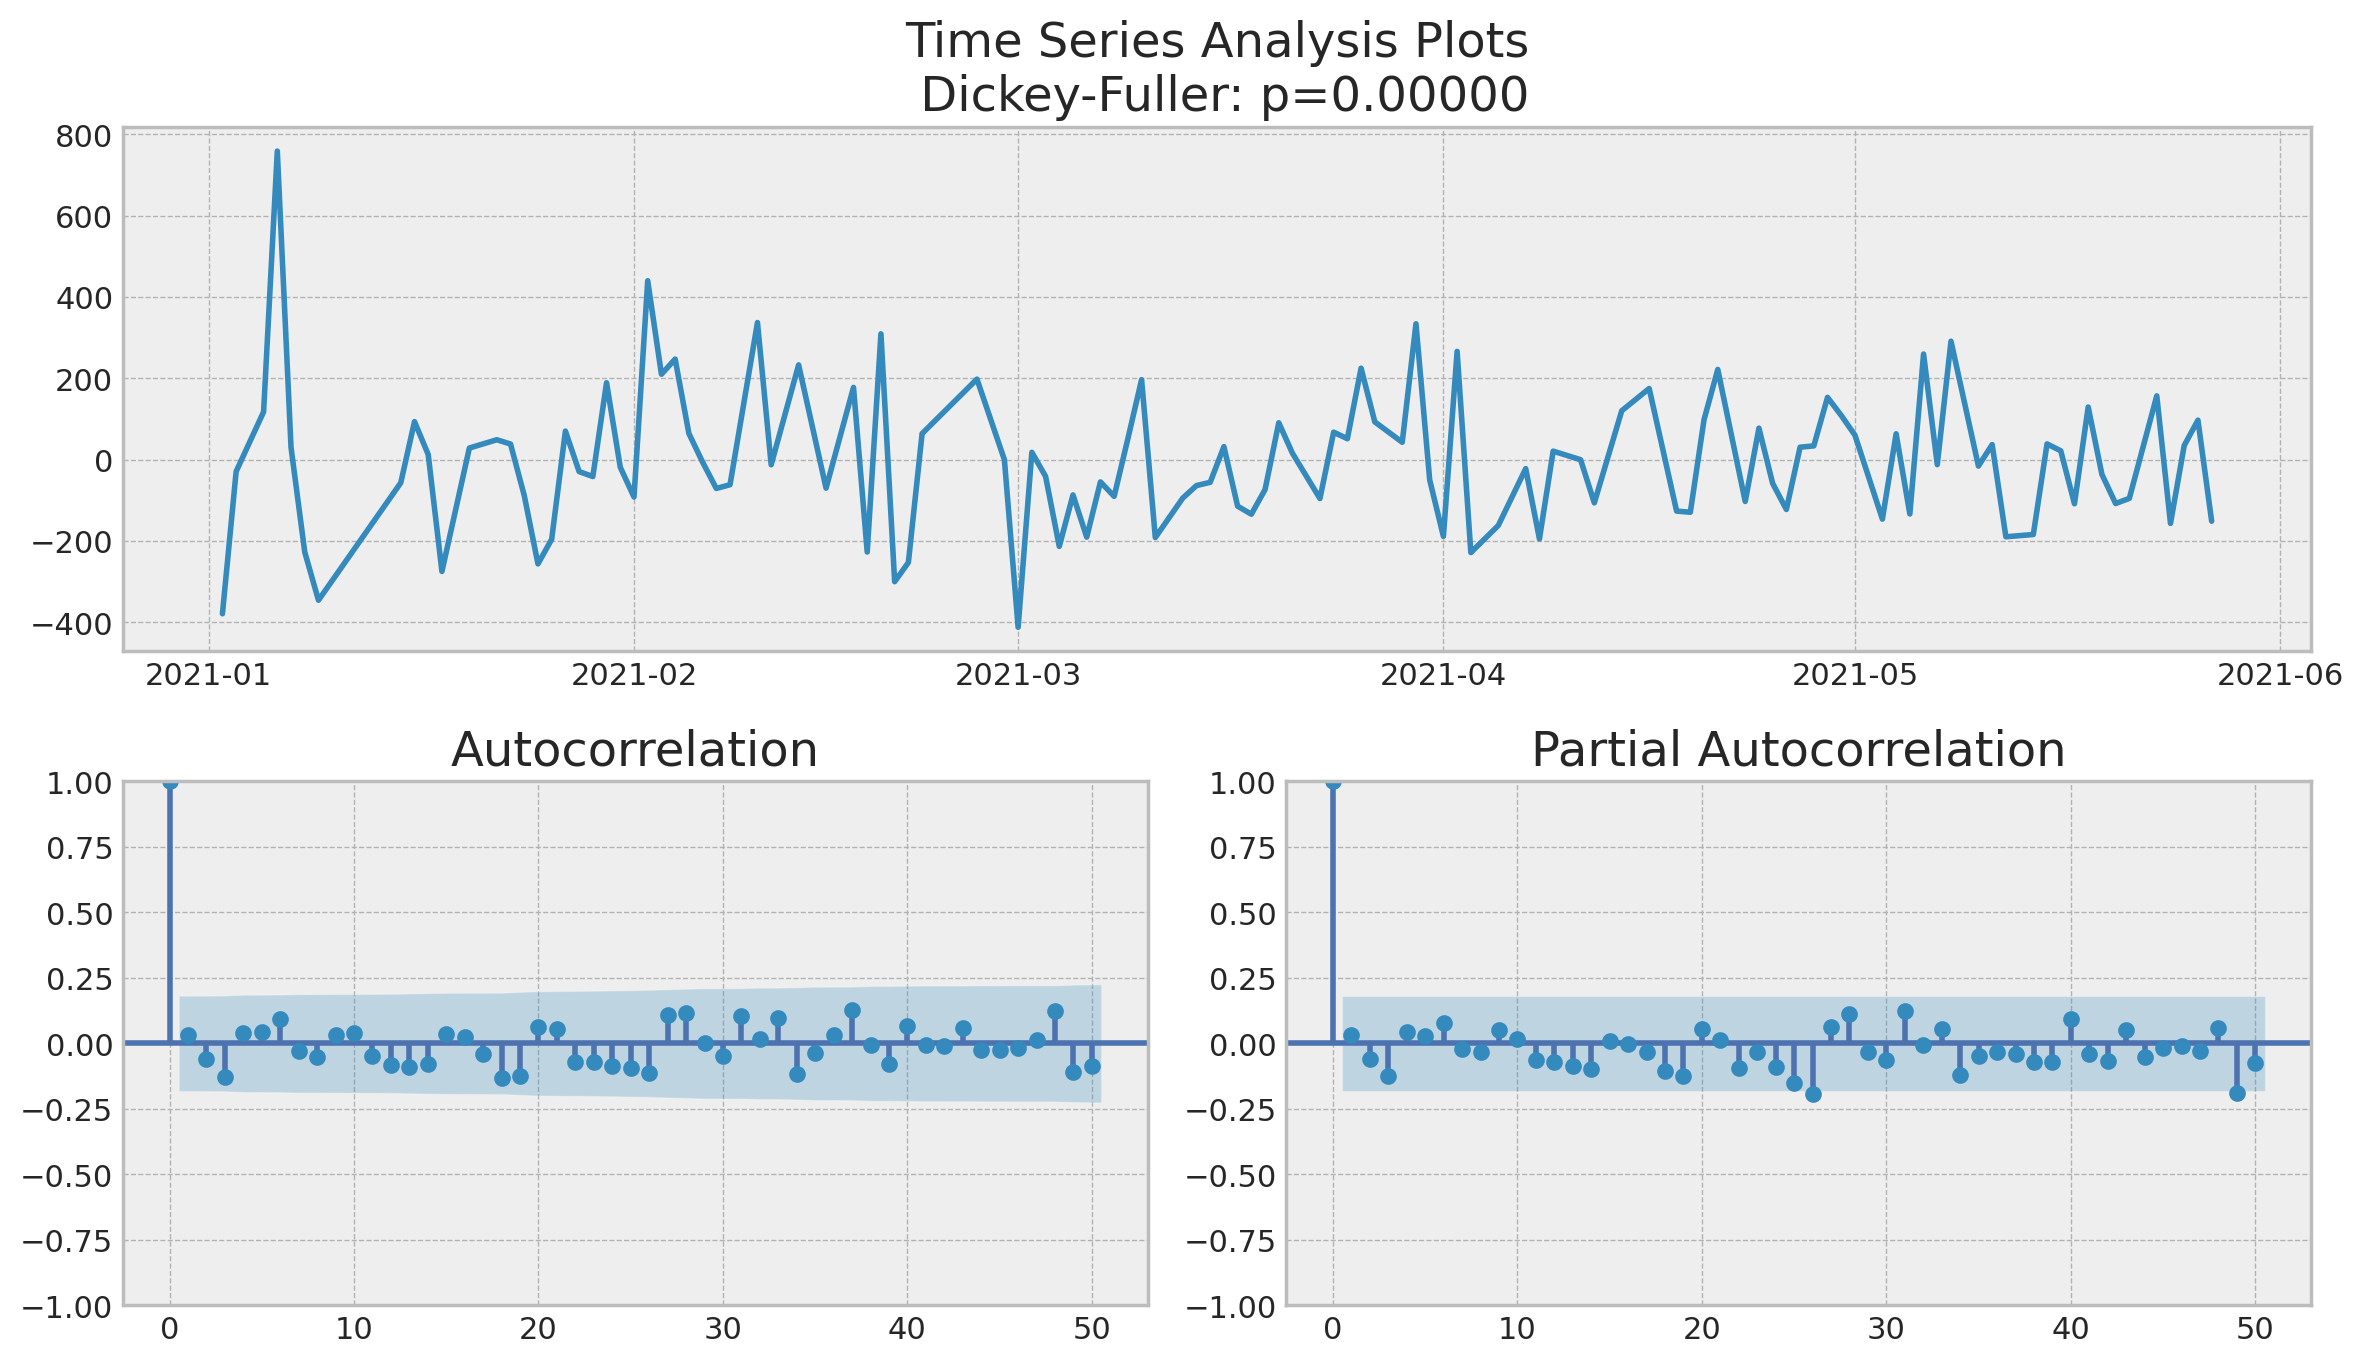

In [17]:
tsplot(best_model.resid[1 :], lags=50)

In [18]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values

        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future

    """
    d=2
    # adding model values
    data = series.copy()
    data.columns = ["actual"]
    data["arima_model"] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data["arima_model"][: d] = np.NaN
    data["arima_model"] = data["arima_model"].shift(-1)

    # forecasting on n_steps forward
    forecast = model.predict(start=data.shape[0], end=data.shape[0] + n_steps)
    #forecast = data.arima_model.append(forecast)
    forecast = forecast.to_numpy()
    forecast_index = pd.date_range(start = data.iloc[-1].name, periods=n_steps+1)
    forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=['forecast'])
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(
        data["actual"][ d :], data["arima_model"][ d :]
    )

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast_df.forecast, label="forecast_arima")
    #plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color="lightgrey")
    plt.plot(data.actual, label="actual")
    plt.plot(data.arima_model, label="arima_model")
    plt.legend()
    plt.grid(True);

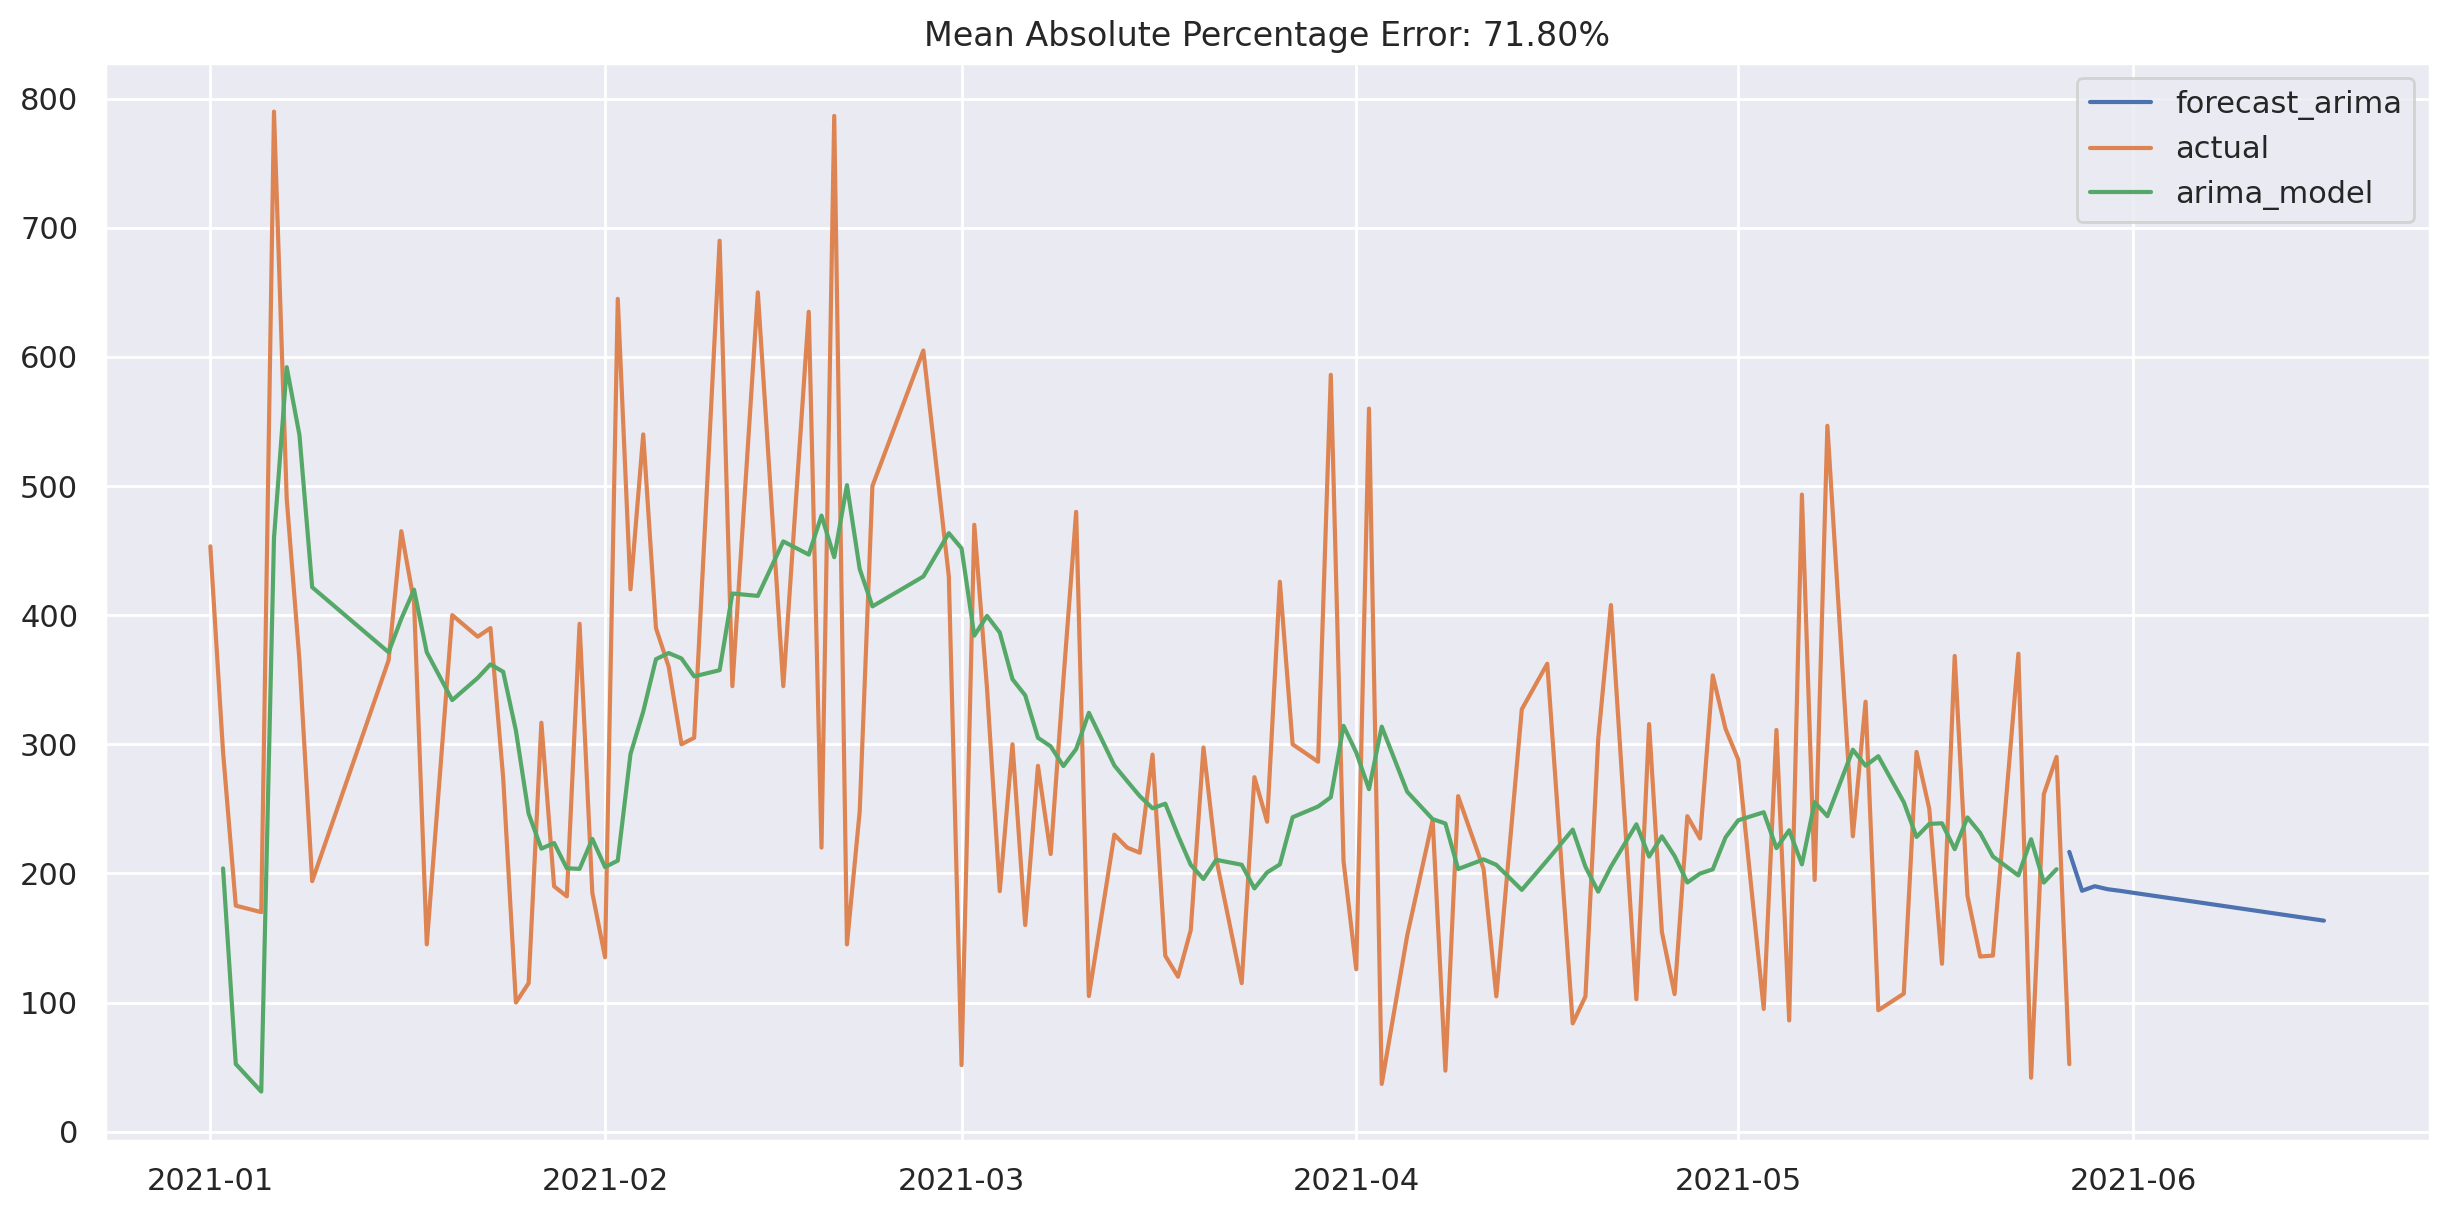

In [19]:
plotSARIMA(df, best_model, 20)

**The techinque showed itself as difficult to tune and control if a user is not familiar with the model and theory behind it. From figure above, it can hardly be called success, although the work may be updated.**